First we are going to load the data.

In [1]:
import csv
import pandas as pd

In [2]:
data = pd.read_csv("./../data/in_silico_growth_curve.csv")

Let's see what the datafile contents are.

In [3]:
data

,times,cells
0,0.000000,8677.144668
1,1.500000,26920.855990
2,3.000000,63176.862474
3,4.500000,249712.054657
4,6.000000,442178.369581
5,7.500001,802923.563655
6,9.000001,875907.621559
7,10.500001,856617.310790
8,12.000001,885705.601724
9,13.500001,912408.715922


It's a very small dataset with just 10 time points showing the number of cells over time. With these short time series, both having a mechanistic model to fit it and having a Bayesian framework to do so helps us to make better sense of the science behind the process. We can visualize the data as.

Text(0, 0.5, 'cells')

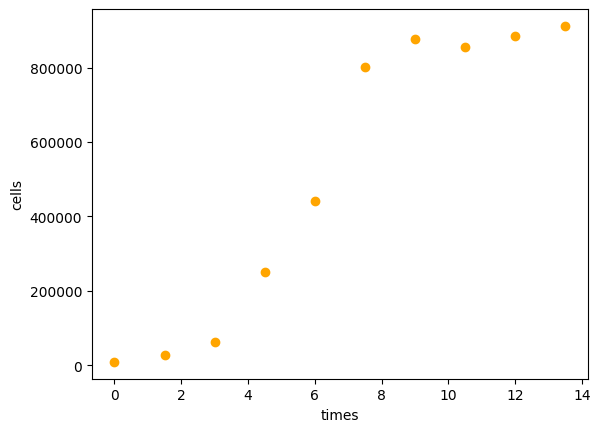

In [4]:
import matplotlib.pyplot as plt
plt.plot(data['times'],data['cells'],'o',color ='orange')
plt.xlabel(data.columns[0])
plt.ylabel(data.columns[1])


However that can be complicated, let's start with the most simple way of fitting a nonlinear ODE model to the data.

### Use of Biological Mechanistic knowledge.
This data is a growth data of the cells where they consume nutrients and we can use the blahblah model

$$
\frac{dN}{dt} = -Q_n \frac{\mu_{max}N}{N+K_s}(P\times10^6)
$$

$$
\frac{dP}{dt} = \frac{\mu_{max}N}{N+K_s} P
$$

### In this dataset the variable 'N' (nutrients) is latent (unobserved)

In [5]:
import numpy as np
from scipy.integrate import odeint
t = np.linspace(0, 15, 100)

def cells_grow(y,t,mu_max,Ks,Qn):
    N, P = y
    dydt = [0,0]
    dydt[0] = -Qn*(mu_max*N)/(N+Ks) *(P*1e6)
    dydt[1] = P*(mu_max*N)/(N+Ks)

    return dydt

def solved_num_cells(y0,t,mu_max,Ks,Qn):
    sol = odeint(cells_grow, y0, t, args=(mu_max,Ks,Qn))
    return sol[:,1]

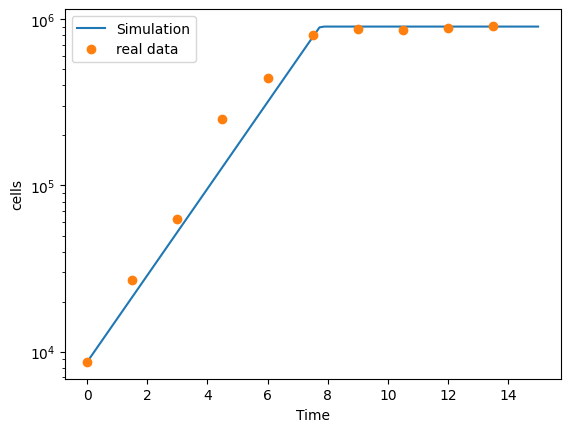

In [6]:
mu_max = 0.6
Ks = 0.09
Qn = 6.7e-10

y0 = [ 6e2, data['cells'][0] ]
num_cells_solved = solved_num_cells(y0,t,mu_max,Ks,Qn)

plt.plot(t,num_cells_solved)
plt.plot(data['times'],data['cells'],'o')
plt.yscale('log')
plt.legend(['Simulation','real data'])
plt.xlabel('Time')
plt.ylabel('cells')
plt.show()


### Using pymc

In [7]:
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [8]:

from numba import njit

In [9]:
@njit
def cells_grow_pymc(y,t,theta):
    # unpack parameters
    N, P = y
    mu_max,Ks,Qn = theta
    
    dp_dt = -Qn*(mu_max*N)/(N+Ks) *(P*1e6)
    dq_dt = P*(mu_max*N)/(N+Ks)

    return [dp_dt, dq_dt]

y0 = [ 6e2, data['cells'][0] ]

In [10]:
# decorator with input and output types a Pytensor double float tensors
import pytensor.tensor as pt
from pytensor.compile.ops import as_op

@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    return odeint(func = cells_grow_pymc, y0=[ 6e2, data['cells'][0] ], t=data['times'], args=(theta,))

### Slice Sampler: default

In [15]:
## Slice Sampler

with pm.Model() as model:
    # Priors
    
    
    # Priors
    mu_max = pm.Normal('mu_max', mu=0.6, sigma=0.06)
    Ks = pm.TruncatedNormal('Ks', mu=0.09, sigma=0.01,  lower=0.05, upper=0.13) 
    #I had to use the truncation, else the proposal samples would go to infeasible values. (Ks<0) and there will be no ODE solutions.
    
    Qn = pm.Lognormal('Qn', mu=np.log(6.7e-10), sigma=1.0)
    sigma = pm.HalfNormal("sigma", 10)

    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([mu_max,Ks,Qn])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=np.log(ode_solution[:,1]), sigma=sigma, observed= np.log(data['cells'].values))


    # Sampling
    trace = pm.sample(2000, tune=1000,step=pm.Slice(), return_inferencedata=True)




Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [mu_max]
>Slice: [Ks]
>Slice: [Qn]
>Slice: [sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.


NameError: name 'az' is not defined

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Ks,0.090,0.010,0.070,0.108,0.000,0.000,6962.0,4997.0,1.0
Qn,0.000,0.000,0.000,0.000,0.000,0.000,8098.0,5300.0,1.0
mu_max,0.679,0.019,0.641,0.715,0.000,0.000,6981.0,4309.0,1.0
sigma,0.157,0.051,0.085,0.248,0.001,0.001,3874.0,3633.0,1.0


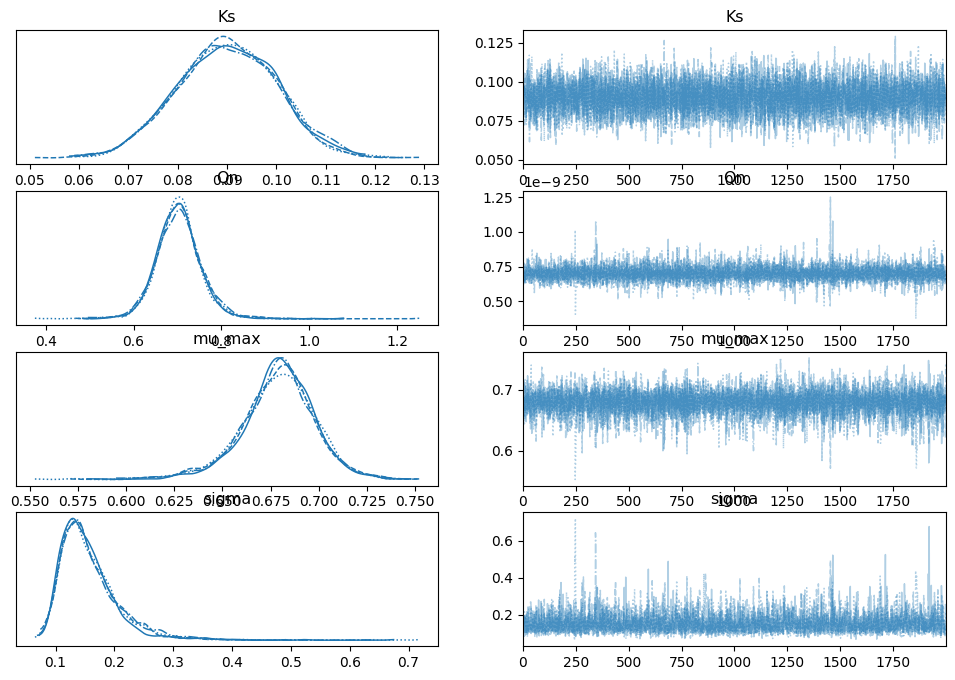

In [16]:
# Summarize results
import arviz as az
az.plot_trace(trace)
az.summary(trace)

In [17]:
def plot_model_trace(ax, trace_df, row_idx, lw=1, alpha=0.2):
    cols = ["mu_max", "Ks", "Qn"]
    row = trace_df.iloc[row_idx, :][cols].values

    time = data['times']
    theta = row
    x_y = odeint(func= cells_grow_pymc, y0 = [ 6e2, data['cells'][0] ], t=time, args=(theta,))
    plot_model(ax, x_y, time=time, lw=lw, alpha=alpha);

In [18]:
def plot_inference(
    ax,
    trace,
    num_samples=200,
    title="Cell growth Bayesian fit",
    plot_model_kwargs=dict(lw=1, alpha=0.2),
):
    trace_df = az.extract(trace, num_samples=num_samples).to_dataframe()
    plot_data(ax, lw=0)
    for row_idx in range(num_samples):
        plot_model_trace(ax, trace_df, row_idx, **plot_model_kwargs)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)

In [19]:
# plot data function for reuse later
def plot_data(ax, lw=2, title="cells growth"):
    ax.plot(data['times'], data['cells'], color="k", lw=lw, marker="o", markersize=12, label="data)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Cells", fontsize=14)
    ax.set_title(title, fontsize=16)
    return ax

In [20]:
# plot model function
def plot_model(
    ax,
    x_y,
    time=data['times'],
    alpha=1,
    lw=3,
    title="bayesian",
):
    ax.plot(time, x_y[:, 1], color="b", alpha=alpha, lw=lw, label="Bayesian")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)
    ax.set_yscale('log')
    return ax

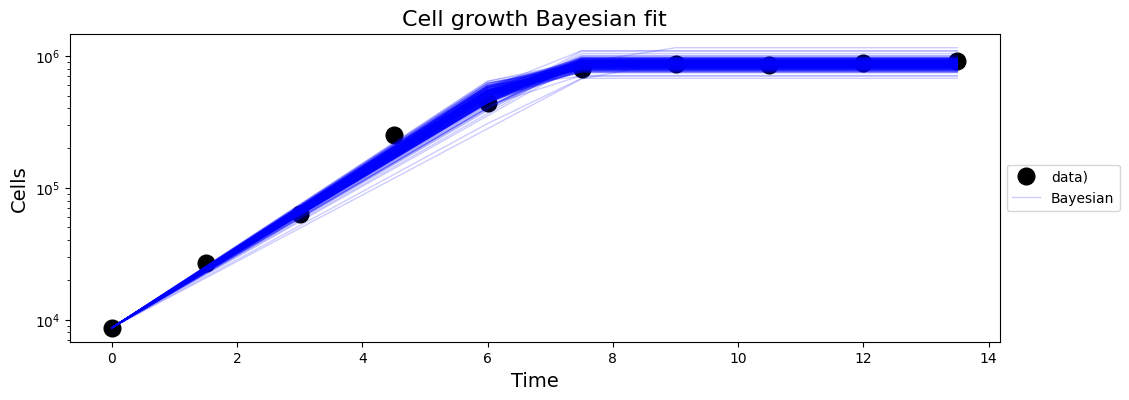

In [21]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace,num_samples=200);

### DEMetropolisZ Sampler: a differential evolution Metropolis sampler that uses the past to inform sampling jumps

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [mu_max, Ks, Qn, sigma]


Output()

Sampling 4 chains for 8_000 tune and 2_000 draw iterations (32_000 + 8_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Ks,0.090,0.010,0.073,0.109,0.000,0.000,597.0,698.0,1.00
Qn,0.000,0.000,0.000,0.000,0.000,0.000,429.0,513.0,1.02
mu_max,0.678,0.019,0.647,0.716,0.001,0.001,524.0,712.0,1.01
sigma,0.160,0.054,0.081,0.253,0.003,0.002,444.0,639.0,1.00


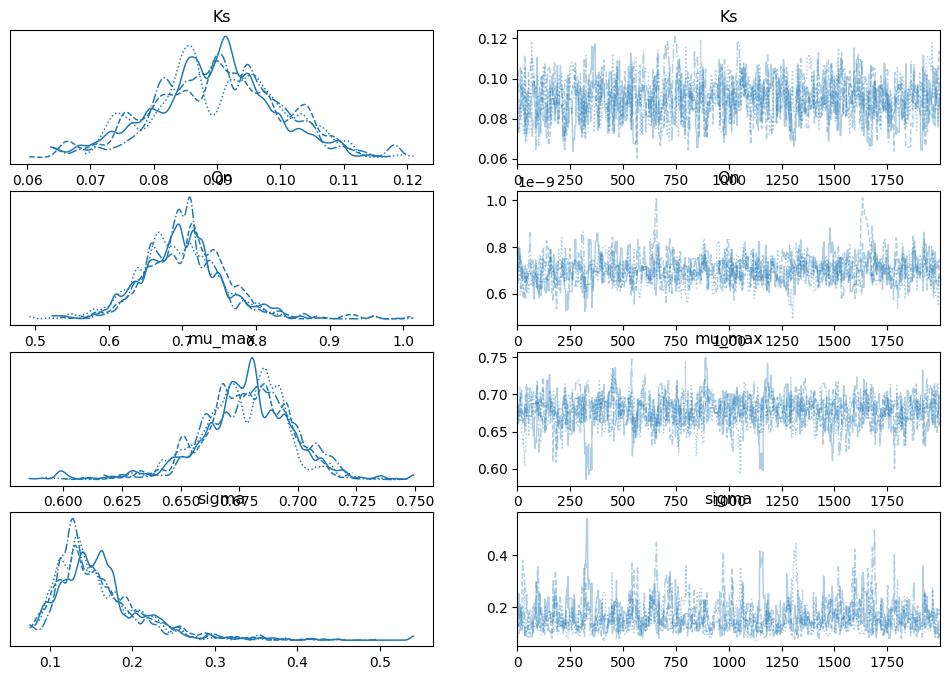

In [25]:
with pm.Model() as model_mz_sampler:
    # Priors
    mu_max = pm.Normal('mu_max', mu=0.6, sigma=0.06)
    Ks = pm.TruncatedNormal('Ks', mu=0.09, sigma=0.01,  lower=0.05, upper=0.13) 
    #I had to use the truncation, else the proposal samples would go to infeasible values. (Ks<0) and there will be no ODE solutions.
    
    Qn = pm.Lognormal('Qn', mu=np.log(6.7e-10), sigma=1.0)
    sigma = pm.HalfNormal("sigma", 10)

    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([mu_max,Ks,Qn])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=np.log(ode_solution[:,1]), sigma=sigma, observed= np.log(data['cells'].values))


    # Sampling
    trace = pm.sample(2000, tune=8000,step=pm.DEMetropolisZ(), return_inferencedata=True)


# Summarize results
az.plot_trace(trace)
az.summary(trace)

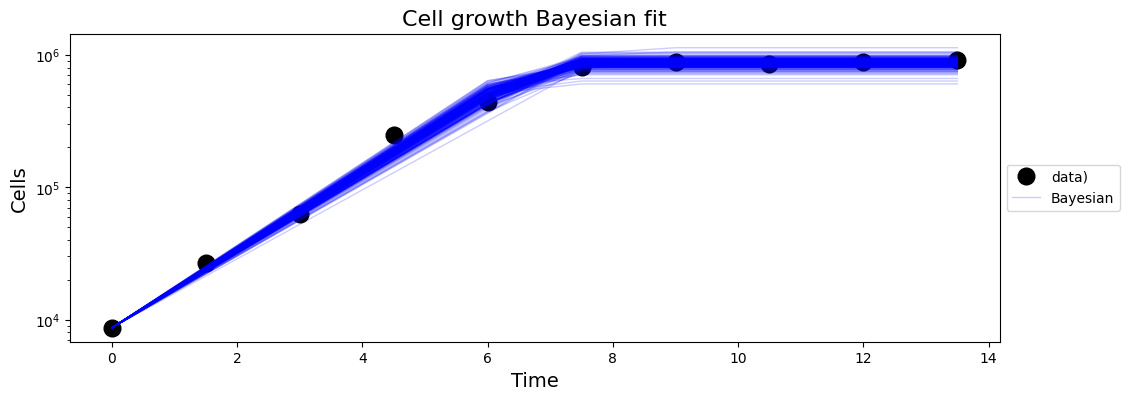

In [26]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace,num_samples=200);

### Metropolis Sampler: Yes the good oldie!

In [31]:
with pm.Model() as model_vaniallametro_sampler:
    # Priors
    mu_max = pm.Normal('mu_max', mu=0.6, sigma=0.06)
    Ks = pm.TruncatedNormal('Ks', mu=0.09, sigma=0.01,  lower=0.05, upper=0.13) 
    #I had to use the truncation, else the proposal samples would go to infeasible values. (Ks<0) and there will be no ODE solutions.
    
    Qn = pm.Lognormal('Qn', mu=np.log(6.7e-10), sigma=1.0)
    sigma = pm.HalfNormal("sigma", 10)

    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([mu_max,Ks,Qn])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=np.log(ode_solution[:,1]), sigma=sigma, observed= np.log(data['cells'].values))


    # Sampling
    trace_metropolis = pm.sample(2000, tune=2000,step=pm.Metropolis(), return_inferencedata=True)



Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu_max]
>Metropolis: [Ks]
>Metropolis: [Qn]
>Metropolis: [sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 12 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Ks,0.090,0.010,0.072,0.108,0.000,0.000,2025.0,1981.0,1.0
Qn,0.000,0.000,0.000,0.000,0.000,0.000,1246.0,1273.0,1.0
mu_max,0.679,0.019,0.641,0.713,0.001,0.000,1170.0,963.0,1.0
sigma,0.155,0.047,0.081,0.238,0.002,0.001,847.0,1111.0,1.0


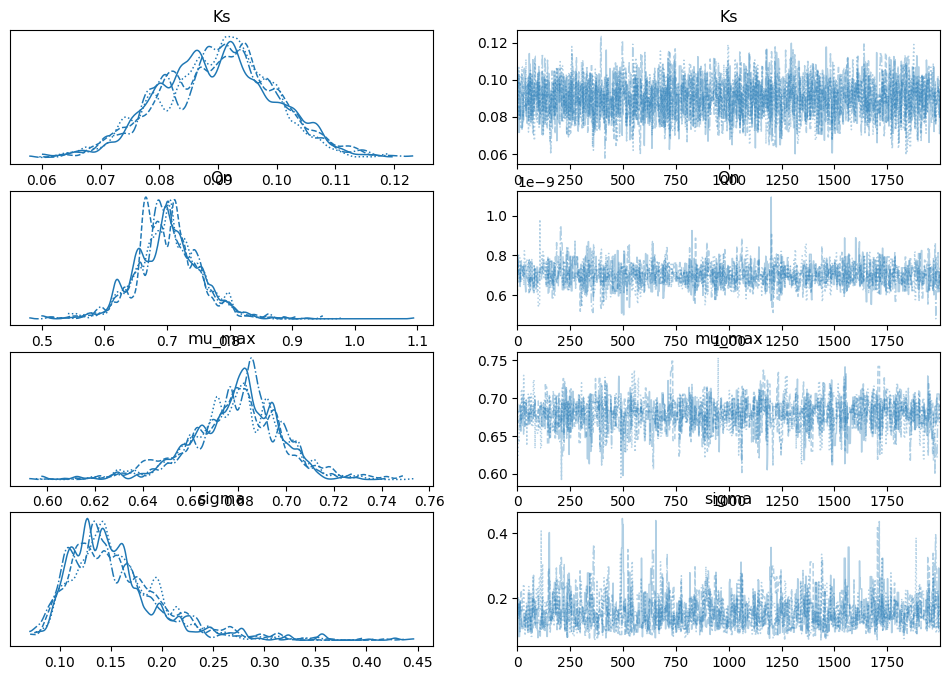

In [32]:
# Summarize results
az.plot_trace(trace_metropolis)
az.summary(trace_metropolis)

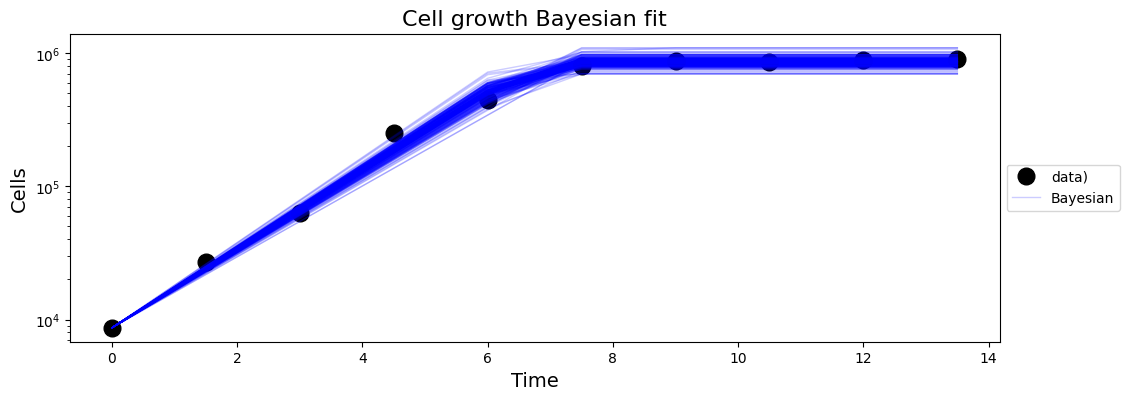

In [33]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace_metropolis,num_samples=200);

### NUTS classic

In [39]:

with pm.Model() as model_nuts_sampler:
    # Priors
    mu_max = pm.Normal('mu_max', mu=0.6, sigma=0.06)
    Ks = pm.TruncatedNormal('Ks', mu=0.09, sigma=0.01,  lower=0.05, upper=0.13) 
    #I had to use the truncation, else the proposal samples would go to infeasible values. (Ks<0) and there will be no ODE solutions.
    
    Qn = pm.Lognormal('Qn', mu=np.log(6.7e-10), sigma=1.0)
    sigma = pm.HalfNormal("sigma", 10)

    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([mu_max,Ks,Qn])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=np.log(ode_solution[:,1]), sigma=sigma, observed= np.log(data['cells'].values))

sampler = "NUTS PyMC ODE"
tune = draws = 1500
with model_nuts_sampler:
    trace_pymc_ode = pm.sample(tune=tune, draws=draws)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Slice: [mu_max]
>>Slice: [Ks]
>>Slice: [Qn]
>NUTS: [sigma]


Output()

Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 26 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Ks,0.090,0.010,0.072,0.110,0.000,0.000,5862.0,4122.0,1.0
Qn,0.000,0.000,0.000,0.000,0.000,0.000,5403.0,2839.0,1.0
mu_max,0.678,0.020,0.641,0.715,0.000,0.000,4431.0,2495.0,1.0
sigma,0.158,0.052,0.084,0.255,0.002,0.001,1279.0,1643.0,1.0


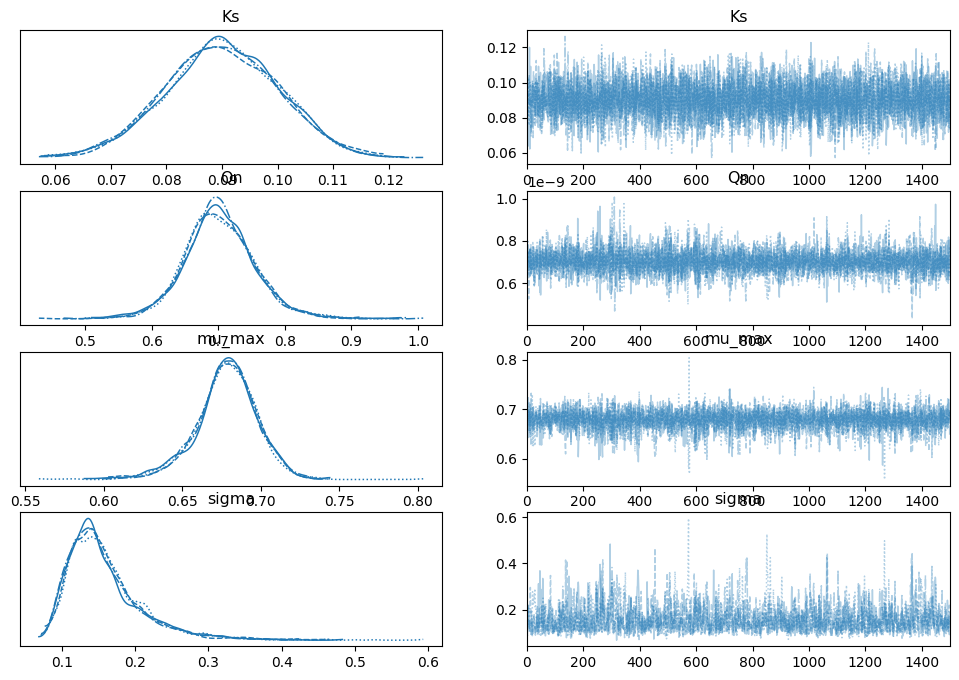

In [41]:
# Summarize results
az.plot_trace(trace_pymc_ode)
az.summary(trace_pymc_ode)

In [46]:

with pm.Model() as model_nuts_sampler:
    # Priors
    mu_max = pm.Normal('mu_max', mu=0.6, sigma=0.06)
    Ks = pm.TruncatedNormal('Ks', mu=0.09, sigma=0.01,  lower=0.05, upper=0.13) 
    #I had to use the truncation, else the proposal samples would go to infeasible values. (Ks<0) and there will be no ODE solutions.
    
    Qn = pm.Lognormal('Qn', mu=np.log(6.7e-10), sigma=1.0)
    sigma = pm.HalfNormal("sigma", 10)

    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([mu_max,Ks,Qn])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=np.log(ode_solution[:,1]), sigma=sigma, observed= np.log(data['cells'].values))

sampler = "NUTS"
tune = draws = 1500
with model_nuts_sampler:
    trace_pymc_ode = pm.sample(tune=tune, draws=draws)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Slice: [mu_max]
>>Slice: [Ks]
>>Slice: [Qn]
>NUTS: [sigma]


Output()

Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 25 seconds.
